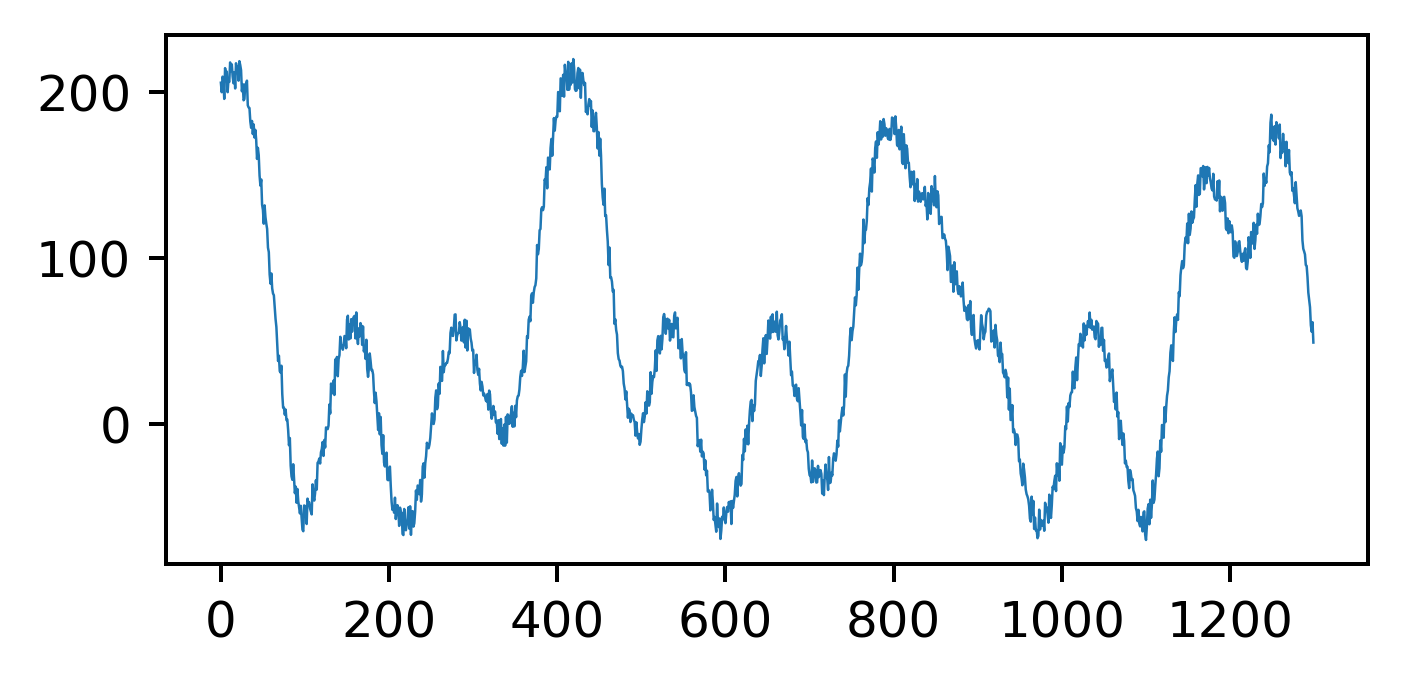

In [91]:
from sklearn.linear_model import LinearRegression
import numpy as np
from plot import plot

def apply_lr(X, y, silent=True):
  X = np.array(X)
  if X.ndim == 1:
    X = X.reshape(-1, 1)
  reg = LinearRegression().fit(X, y)
  if not silent:
    print('score', reg.score(X, y))
    print('coef_', reg.coef_)
    print('intercept_', reg.intercept_)
  return reg, reg.score(X, y), reg.coef_, reg.intercept_

def mae(y, y_hat):
	y = np.array(y)
	y_hat = np.array(y_hat)
	return np.mean(np.abs(y - y_hat))

def rmse(y, y_hat):
  return np.sqrt(np.mean(np.square(y - y_hat)))

generator = np.random.default_rng(42)

series = np.concatenate([
  np.array(generator.uniform(-10, 10, 100)) + np.linspace(0, 200, 100)[::-1],
  
  np.array(generator.uniform(-10, 10, 200)),
  np.array(generator.uniform(-10, 10, 150)) + np.linspace(0, 200, 150),
  np.array(generator.uniform(-10, 10, 50)) + np.linspace(0, 200, 50)[::-1],

  np.array(generator.uniform(-10, 10, 200)),
  np.array(generator.uniform(-10, 10, 150)) + np.linspace(0, 200, 150),
  np.array(generator.uniform(-10, 10, 50)) + np.linspace(0, 200, 50)[::-1],

  np.array(generator.uniform(-10, 10, 200)),
  np.array(generator.uniform(-10, 10, 150)) + np.linspace(0, 200, 150),
  np.array(generator.uniform(-10, 10, 50)) + np.linspace(0, 200, 50)[::-1],
])
series = series + (np.sin([(i/20) for i in range(len(series))])*60)
plot(series)

In [92]:
segments = []
for i in range(0, len(series), 2):
  seg = series[i:i+2]
  model, _, coef, intercept = apply_lr(list(range(i, i+2)), seg)
  error = mae(seg, model.predict(np.array(range(i, i+2)).reshape(-1, 1)))
  segments.append({'model': model, 'start': i, 'end': i+1, 'seg': seg, 'error': error})

erro_seg_inicio = sum([seg['error'] for seg in segments])

In [93]:
original_model, _, coef, intercept = apply_lr(np.array(range(len(series))), series)
full_error = mae(series, original_model.predict(np.array(range(len(series))).reshape(-1, 1)))

In [94]:
curr_error = 0
error_threshold = full_error * 0.05
while curr_error < error_threshold:
# while len(segments) > 10:
  errors = []
  for i in range(len(segments)-1):
    seg1 = segments[i]
    seg2 = segments[i+1]
    combined_segs = [*seg1['seg'], *seg2['seg']]
    m_model, _, m_coef, m_intercept = apply_lr(np.array(range(seg1['start'], seg2['end']+1)), combined_segs)

    m_error = mae(combined_segs, m_model.predict(np.array(range(seg1['start'], seg2['end']+1)).reshape(-1, 1)))

    diff = m_error - (seg1['error'] + seg2['error'])/2

    errors.append(
      {'model': m_model, 'start': seg1['start'], 'end': seg2['end'], 'seg': combined_segs, 'error': m_error, 'diff': diff})

  min_loss = np.argmin([e['diff'] for e in errors])

  segments.pop(min_loss)
  segments.pop(min_loss)
  segments.insert(min_loss, errors[min_loss])
  predicted_series = []
  for seg in segments:
    prediction = seg['model'].predict(np.array(range(seg['start'], seg['end']+1)).reshape(-1, 1))
    predicted_series = [*predicted_series, *prediction]
  curr_error = mae(series, predicted_series)

In [95]:
print('erro sem segmentação', full_error)
print('erro segmentado antes', erro_seg_inicio)
print('erro segmentado depois', sum([seg['error'] for seg in segments]))
print('Numero de segmentos: ', len(segments))

erro sem segmentação 62.47307242920065
erro segmentado antes 1.9208279411486728e-10
erro segmentado depois 184.30131757985464
Numero de segmentos:  223


In [96]:
predicted_series = []
for seg in segments:
  prediction = seg['model'].predict(np.array(range(seg['start'], seg['end']+1)).reshape(-1, 1))
  predicted_series = [*predicted_series, *prediction]
  # plot(seg['seg'], sec_plots=[prediction], title=e)
error = mae(series, predicted_series)

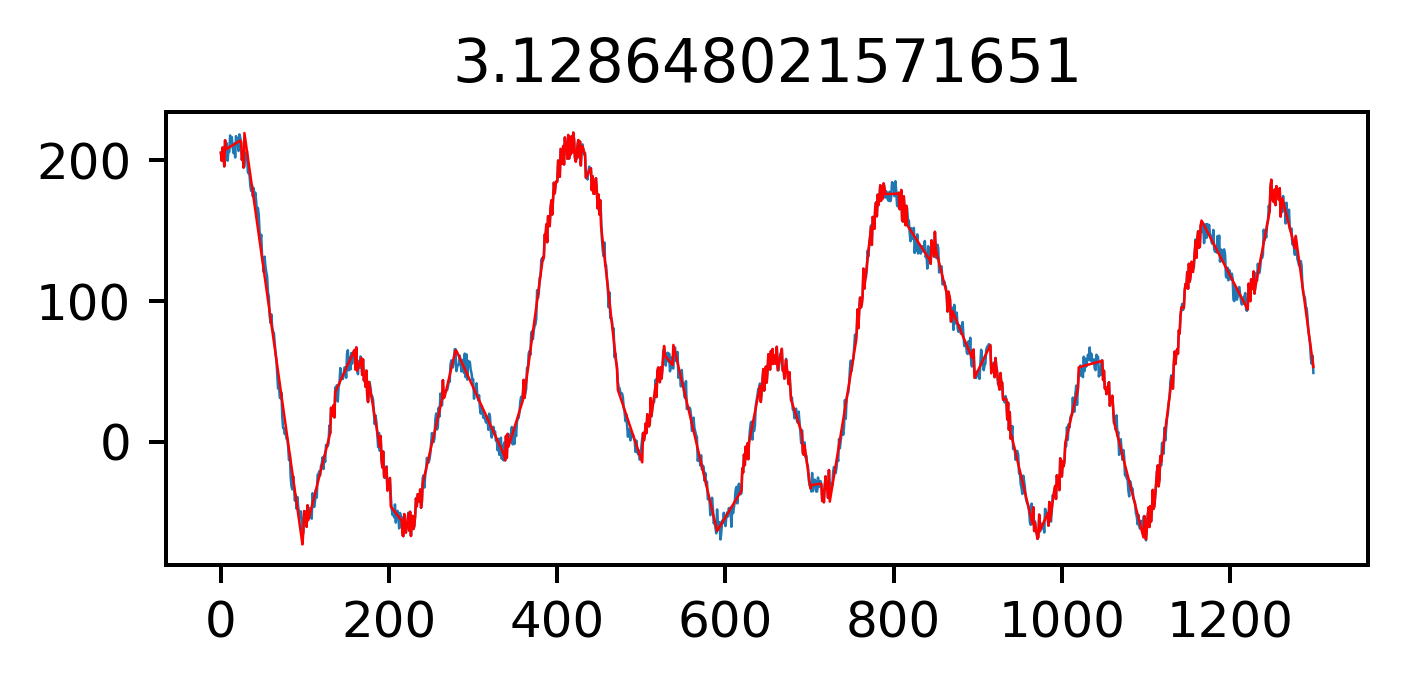

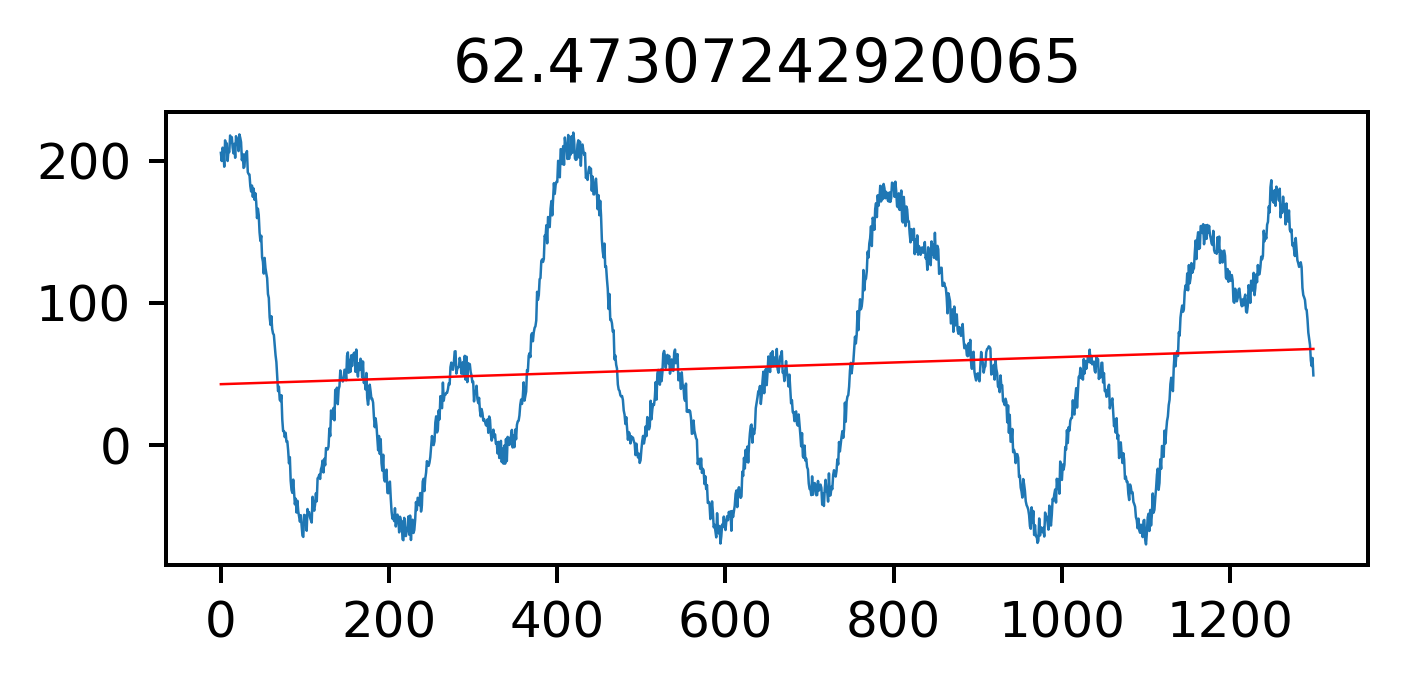

In [97]:
plot(series, sec_plots=[predicted_series], title=error)
plot(series, sec_plots=[original_model.predict(np.array(range(len(series))).reshape(-1, 1))], title=full_error)